# Import Python packages

In [ ]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

import json
import requests
import random
import time

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'
print('TensorFlow version: {}'.format(tf.__version__))

# Load Fashion MNIST data

In [ ]:
fashionmnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashionmnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

# Build Version 1 of the Fashion MNIST image classification model

In [ ]:
model1 = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model1.summary()

epochs = 5

compilation_args = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "metrics": ['accuracy']
}

model1.compile(**compilation_args)
model1.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

# save it
MODEL_DIR='./models/1'
model1.save(MODEL_DIR)

# reconstruct it by loading
reconstructed_model1 = keras.models.load_model(MODEL_DIR)
# compile the loaded model
reconstructed_model1.compile(**compilation_args)

# ensure loaded model returns same predictions as saved model
reconstructed_test_loss, reconstructed_test_acc = reconstructed_model1.evaluate(test_images, test_labels)
np.testing.assert_allclose(
    model1.predict(test_images), reconstructed_model1.predict(test_images)
)

print('\nReconstructed test accuracy: {}'.format(reconstructed_test_acc))

# Build Version 2 of the Fashion MNIST image classification model

In [ ]:
model2 = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=16, kernel_size=4, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model2.summary()

epochs = 5

model2.compile(**compilation_args)
model2.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

# save it
MODEL_DIR='./models/2'
model2.save(MODEL_DIR)

# reconstruct it by loading
reconstructed_model2 = keras.models.load_model(MODEL_DIR)
# compile the loaded model
reconstructed_model2.compile(**compilation_args)

# ensure loaded model returns same predictions as saved model
reconstructed_test_loss, reconstructed_test_acc = reconstructed_model2.evaluate(test_images, test_labels)
np.testing.assert_allclose(
    model2.predict(test_images), reconstructed_model2.predict(test_images)
)

print('\nReconstructed test accuracy: {}'.format(reconstructed_test_acc))

# Build Version 3 of the Fashion MNIST image classification model

In [ ]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(32, (2, 2), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dropout(rate = 0.5))
model3.add(layers.Dense(10, activation=tf.nn.softmax))

model3.summary()

epochs = 20

model3.compile(**compilation_args)
model3.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

# save it
MODEL_DIR='./models/3'
model3.save(MODEL_DIR)

# reconstruct it by loading
reconstructed_model3 = keras.models.load_model(MODEL_DIR)
# compile the loaded model
reconstructed_model3.compile(**compilation_args)

# ensure loaded model returns same predictions as saved model
reconstructed_test_loss, reconstructed_test_acc = reconstructed_model3.evaluate(test_images, test_labels)
np.testing.assert_allclose(
    model3.predict(test_images), reconstructed_model3.predict(test_images)
)

print('\nReconstructed test accuracy: {}'.format(reconstructed_test_acc))

# Create container images for the three model versions

### These models are already dockerized and available from docker hub as pre-built images and are named/tagged as iter8/fashionmnist:v1, iter8/fashionmnist:v2, and iter8/fashionmnist:v3 respectively.

### For building your own images from these models, refer to instructions on https://github.com/iter8-tools/mlops.


# Serve the model images on a Kubernetes cluster
### For deploying these on a Kubernetes cluster, refer to instructions on https://github.com/iter8-tools/mlops.

# Send an image to the deployed model

In [22]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

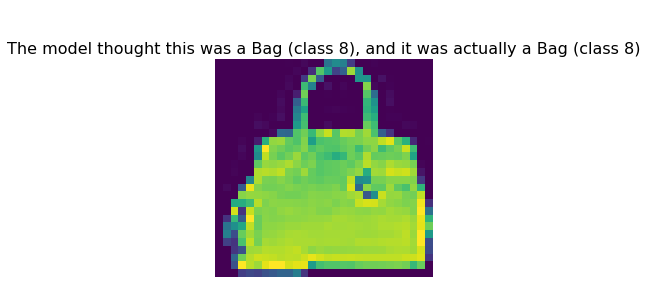

In [30]:
# Depending upon where you are running the model, you will need to change the gateway_url below.

# The code below determines the gateway_url for Kubernetes + istio on a Minikube environment 
# with Docker driver and a minikube tunnel.

# If you are serving the model on any other (non-Minikube) Kubernetes cluster with Istio installed, 
# refer to instructions here on determining your gateway_url
# https://istio.io/latest/docs/setup/getting-started/#determining-the-ingress-ip-and-ports

ingress_host_list = !(minikube ip)
# ingress_port_list = !(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.spec.ports[?(@.name=="http2")].nodePort}')
ingress_port_list = [80]
gateway_url = "http://{}:{}".format(ingress_host_list[0], ingress_port_list[0])
model_url = "{}/v1/models/fashionmnist:predict".format(gateway_url)

rando = random.randint(0,len(test_images)-1)
data = json.dumps({"signature_name": "serving_default", "instances": test_images[rando:rando + 1].tolist()})
headers = {"content-type": "application/json", "host": "fashionmnist.com"}
json_response = requests.post(model_url, data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(rando, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[rando]], test_labels[rando]))

# Send serialized images for classification to the model service

In [ ]:
# Depending upon where you are running the model, you will need to change the gateway_url below.

# The code below determines the gateway_url for Kubernetes + istio on a Minikube environment 
# with Docker driver and a minikube tunnel.

# If you are serving the model on any other (non-Minikube) Kubernetes cluster with Istio installed, 
# refer to instructions here on determining your gateway_url
# https://istio.io/latest/docs/setup/getting-started/#determining-the-ingress-ip-and-ports

ingress_host_list = !(minikube ip)
# ingress_port_list = !(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.spec.ports[?(@.name=="http2")].nodePort}')
ingress_port_list = [80]
gateway_url = "http://{}:{}".format(ingress_host_list[0], ingress_port_list[0])
model_url = "{}/v1/models/fashionmnist:predict".format(gateway_url)


for i in range(100000): # send a image at random to the model server and get back the prediction; do it a 1000 times.
    rando = random.randint(0,len(test_images)-1)
    data = json.dumps({"signature_name": "serving_default", "instances": test_images[rando:rando + 1].tolist()})
    json_response = requests.post(model_url, data=data, headers=headers)
    try:
        predictions = json.loads(json_response.text)['predictions']
    except ValueError as e:
        print("Error: ", e)
        print(json_response)
        print(json_response.text)
    
    if i % 50 == 0:
        print('The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
            class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[rando]], test_labels[rando]))

    time.sleep(0.1)

The model thought this was a Sneaker (class 7), and it was actually a Sneaker (class 7)
The model thought this was a Coat (class 4), and it was actually a Coat (class 4)
The model thought this was a Dress (class 3), and it was actually a Dress (class 3)
The model thought this was a Sandal (class 5), and it was actually a Sandal (class 5)
The model thought this was a Sandal (class 5), and it was actually a Sandal (class 5)
The model thought this was a T-shirt/top (class 0), and it was actually a T-shirt/top (class 0)
Error:  Expecting value: line 1 column 1 (char 0)
<Response [503]>
no healthy upstream
Error:  Expecting value: line 1 column 1 (char 0)
<Response [503]>
no healthy upstream
Error:  Expecting value: line 1 column 1 (char 0)
<Response [503]>
no healthy upstream
The model thought this was a Pullover (class 2), and it was actually a Pullover (class 2)
The model thought this was a T-shirt/top (class 0), and it was actually a T-shirt/top (class 0)
Error:  Expecting value: line 1